# Modélisation via Python
## Résolution numérique du problème
#### 1. Simulation de l'évolution d'une épidémie par le modèle SIR
On commence par importer les librairies python que nous utiliserons plus tard...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

#### Etude numérique de la méthode d'Euler :
Définition de euler() :

In [2]:
def euler(f,y0,t0,T,n):
    t = np.zeros(n)
    y = np.zeros(n)
    y[0] = y0
    t[0] = t0
    h = (T-t0)/n
    for k in (range(n-1)):
        t[k+1] = t[k] + h
        y[k+1] = y[k] + h*f(y[k],t[k])
    return y

Définition de compare() :

In [3]:
def compare(y_euler,f_true,t0,T,n):
    fig = plt.figure() #fig non utilisée??
    t_euler = np.linspace(t0,T,n)
    t_true = np.linspace(t0,T,(T-t0)*100)
    y_true = f_true(t_true) #would be better to plot the real function instead of many points
    plt.plot(t_euler,y_euler,'b.-',t_true,y_true,'r-')
    plt.title("Comparaison de courbes")
    plt.show()

On run compare() :

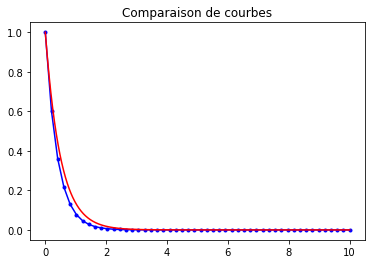

In [4]:
    f = lambda y,t : -2*y
    y0 = 1
    t0 = 0
    T = 10
    n = 100

    y_euler = euler(f,y0,t0,T,n)

    f_true = lambda t : np.exp(-2*t)

    compare(y_euler,f_true,t0,T,n)

#### On modélise maintenant une épidémie à l'aide d'un modèle SIR : 
On commence par mettre sous forme de fonction les équations différentielles partielles présentées plus tôt :

In [5]:
def f(y,beta,lambd):
    (S,I,R) = y[:,0]
    x = np.array([[-beta*I*S], [beta*I*S - I/lambd], [I/lambd]])
    return x

On affiche les différentes fonctions à l'aide de matplot :

In [6]:


def schema_num(methode,I0,t0,T,n,beta,Lambda,S_state,I_state,R_state):
    """ Programme renvoyant une matrice comprenant les valeurs itérées de S, I et R 
    selon la méthode choisie, pour t allant de t0 à T"""
    h = (T-t0)/n
    liste = np.array([[1.0-I0],[I0],[0]])
    y = np.array([[1.0-I0],[I0],[0]])

    
    for k in range(n-1):
        if methode == "Euler":
            y = y + h*f(y,beta,Lambda)
        if methode == "Euler modifiée":
            y = y + h*f(y+h/2*f(y,beta,Lambda),beta,Lambda)
        if methode == "Runge-Kutta d'ordre 2":
            y = y + h/2*(f(y,beta,Lambda)+f(y+h*f(y,beta,Lambda),beta,Lambda))
        if methode == "Runge-Kutta d'ordre 4":
            k1 = f(y,beta,Lambda)
            k2 = f(y + h/2*k1,beta,Lambda)
            k3 = f(y + h/2*k2,beta,Lambda)
            k4 = f(y + h*k3,beta,Lambda)
            y = y + h/6*(k1+2*k2+2*k3+k4)
        liste = np.append(liste,y,1)
    t = np.linspace(t0,T,n)
    plt.figure(figsize=(12, 7))
    plt.xlim(xmin=0,xmax=T)
    if S_state:
        plt.plot(t, liste[0], label='S')
    if I_state:
        plt.plot(t, liste[1], label='I')
    if R_state:
        plt.plot(t, liste[2], label='R')
    plt.title("Tracé du modèle SIR grâce à la méthode "+methode ,fontsize=16)
    plt.legend()
    plt.show()

widgets.interact(schema_num, Lambda = widgets.FloatSlider(value=5.0,min=0.1,max=10.0,step=0.1),beta = widgets.FloatSlider(value=1.0,min=0.1,max=10.0,step=0.1), I0 = widgets.FloatSlider(value=0.1,min=0.0,max=1.0,step=0.01), n=widgets.IntSlider(value=200,min=20,max=1000,step=10),methode = ['Euler','Euler modifiée',"Runge-Kutta d'ordre 2","Runge-Kutta d'ordre 4"],t0=widgets.fixed(0),T=widgets.IntSlider(value=50,min=10,max=500,step=10),S_state = widgets.Checkbox(value=True,description='S'),I_state = widgets.Checkbox(value=True,description='I'),R_state = widgets.Checkbox(value=True,description='R'));

interactive(children=(Dropdown(description='methode', options=('Euler', 'Euler modifiée', "Runge-Kutta d'ordre…

#### Simulation réaliste qualitative :

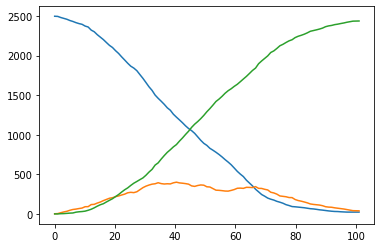

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import matplotlib.image as mpimg

CONTAGION = 0.1 #10% of chances to infect adjacent cell
RECOVER = 0.1 #10% chance to recover

def decision(probability): #returns boolean probabilistically based
    return random.random() < probability

class Cell:
    def __init__(self,line, column, state):
        self.line = line
        self.column = column
        self.state = state #state 0: Susceptible, 1: Infectious, 2: Recoverd (SIR MODEL)

    def tick(self):
        print('cell at pos ' + str(self.line) + ',' + str(self.column) + ' Ticked !')
        if self.state == 1:
            self.infect()
            self.recover()
        return
    
    def infect(self):
        self.state = 1
        return
    
    def recover(self):
        self.state = 2
        return


class CellMap:
    def __init__(self,lines,columns):
        self.SIR = [0,0,0]
        self.createMap(lines,columns)
        self.lines = lines
        self.columns = columns


    
    def createMap(self,lines,columns):
        array = np.zeros((lines,columns))
        array = array.astype('object_') #allows to store any object, not only floats
        printableArray = np.zeros((lines,columns))
    
        for l in range(array.shape[0]):
            for c in range(array.shape[1]):
                array[l,c] = Cell(l,c,0)
                printableArray[l,c] = 0
        
        self.cellArray = array.copy()
        self.printableArray = printableArray.copy()
        self.SIR[0] = self.cellArray.shape[0]*self.cellArray.shape[1]


    def tick(self):
        nextCellArray = self.cellArray.copy()
        for l in range(self.cellArray.shape[0]):
            for c in range(self.cellArray.shape[1]):
                
                cell = self.cellArray[l,c]
                if cell.state == 1:
                    # print(str(l) + ',' + str(c))
                    for lAdjacent,cAdjacent in self.AdjacentCells(l,c):
                        # print(str(lAdjacent) + ',' + str(cAdjacent))
                        if decision(CONTAGION):
                            self.infectCell(lAdjacent,cAdjacent,nextCellArray)

                    if decision(RECOVER): #at term we will need to implement it as a normal map
                        self.recoverCell(l,c,nextCellArray)
        # print(self.SIR)

        
        self.cellArray = nextCellArray.copy()

    def infectCell(self,l,c,cellArray = None):
        if cellArray is None:
            cellArray = self.cellArray
        
        if cellArray[l,c].state ==0:
            cellArray[l,c].infect()
            self.printableArray[l,c] = 1  
            self.SIR[0] -= 1
            self.SIR[1] += 1        

    def recoverCell(self,l,c,cellArray = None):
        if cellArray is None:
            cellArray = self.cellArray
        cellArray[l,c].recover()
        self.printableArray[l,c] = 2    
        self.SIR[1] -= 1
        self.SIR[2] += 1                   

    def AdjacentCells(self,l,c):
        adjacentCells = []
        for lOffset in range(-1,2):
            for cOffset in range(-1,2):
                if l + lOffset in range(self.lines) and c + cOffset in range(self.columns) and (l + lOffset != l or c + cOffset != c):
                    adjacentCells.append((l+lOffset,c+cOffset))
        # adjacentCells = [(l-1,c-1),(l-1,c),(l-1,c+1),(l,c-1),(l,c+1),(l+1,c-1),(l+1,c),(l+1,c+1)]
        
        # print(adjacentCells)
        return adjacentCells
    
    def placeInitialInfected(self,numberOfInitialInfected):
        for i in range(numberOfInitialInfected):
            l = random.randrange(self.lines)
            c = random.randrange(self.columns)
            self.infectCell(l,c)




class Simulation:
    def __init__(self,cellMap):
        self.cellMap = cellMap
        self.steps = [[],[],[],[]] #each simulation steps [printableMatrixList],[SList],[IList],[RList]
        
        

    def plot(self):
        t = np.linspace(0,self.numberOfTicks +1 ,self.numberOfTicks +1)

        SList = self.steps[1]
        IList = self.steps[2]
        RList = self.steps[3]

        S = plt.plot(t, SList, label='S')
        I = plt.plot(t, IList, label='I')
        R = plt.plot(t, RList, label='R')
        plt.show()
        return
    
    def run(self,numberOfTicks):
        self.numberOfTicks = numberOfTicks
        self.steps[0].append(self.cellMap.printableArray.copy())
        self.steps[1].append(self.cellMap.SIR[0])
        self.steps[2].append(self.cellMap.SIR[1])
        self.steps[3].append(self.cellMap.SIR[2])
        for i in range(numberOfTicks):
            self.cellMap.tick()
            self.steps[0].append(self.cellMap.printableArray.copy())
            self.steps[1].append(self.cellMap.SIR[0])
            self.steps[2].append(self.cellMap.SIR[1])
            self.steps[3].append(self.cellMap.SIR[2])
        return

    def generateGIF(self):
        images = []

        width = 1000
        cellWidth = width // self.cellMap.lines

        def drawImage(printableCellArray):
            im = Image.new('RGB',(width,width))
            draw = ImageDraw.Draw(im)
            for l in range(printableCellArray.shape[0]):
                for c in range(printableCellArray.shape[1]):
                    color = 'black'
                    if printableCellArray[l,c] == 0:
                        color = 'green'
                    elif printableCellArray[l,c] == 1:
                        color = 'red'
                    elif printableCellArray[l,c] == 2:
                        color = 'yellow'
                    # draw.rectangle([cellWidth*(printableCellArray.shape[0] - l),cellWidth*c,cellWidth*(printableCellArray.shape[0] - l + 1),cellWidth*(c + 1)],color,'black',width=2)
                    draw.rectangle([cellWidth*c,cellWidth*(printableCellArray.shape[0] - l - 1),cellWidth*(c + 1),cellWidth*(printableCellArray.shape[0] - l)],color,'black',width=1)
            images.append(im)

        for step in self.steps[0]:
            drawImage(step)

        images[0].save('cells.gif',save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)


if __name__ =='__main__':
    cellMap = CellMap(50,50) 
    cellMap.placeInitialInfected(2)
    simulation = Simulation(cellMap)
    simulation.run(100)
    simulation.generateGIF()
    simulation.plot()

In [13]:
from IPython.display import HTML
HTML('<img src="cells.gif">')